# End-to-End Credit Risk Prediction: Mitigating Loss and Maximizing Profit in P2P Investments
_by Bashara Aina_

This project aims to develop an end-to-end solution for credit risk prediction in collaboration with a lending company during my internship as a Data Scientist at ID/X Partners. The objective is to create a machine learning model that can effectively identify potentially bad or risky loans, providing valuable insights for investment decision-making.

* Problem:
  As investors in P2P platforms, we face the risk of loans being charged off or defaulted, resulting in financial   losses. The challenge at hand is to develop a reliable system that can accurately predict the credit risk        associated with loans, allowing us to minimize our losses.

* Business Metrics:
  The success of our solution will be measured by two key business metrics: loss and net profit margin. By accurately identifying and avoiding risky loans, we aim to reduce overall losses and improve our net profit margin.

* Solution Explanation:
  To address the problem, we will leverage machine learning algorithms and utilize a comprehensive dataset provided by the lending company. The dataset consists of historical loan data from the Lending Club, covering the period between 2007 and 2014. By analyzing this data, we will build a predictive model that can assess the credit risk of new loan applications.

* Approach:
  To ensure simplicity and practicality, we will focus on non-parametric algorithms that require fewer assumptions. This approach allows us to develop a reliable model without extensive statistical expertise. Our end-to-end solution will involve various stages, including data preprocessing, feature engineering, model development, and evaluation.

*  Deliverables:
   As part of our project, we will prepare clear and concise visual media to present our solution to the lending company. These visualizations will effectively communicate our findings and insights, aiding in decision-making processes.

By successfully implementing this end-to-end solution, we aim to minimize financial losses by avoiding risky   loans and increase our net profit margin in P2P platforms. This collaborative effort between ID/X Partners and Rakamin Academy showcases our commitment to applying data science methodologies in real-world scenarios, driving meaningful outcomes.

## Importing Packages and Preparing Functions

In [1]:
# Import necessary packages for the project

# Data manipulation
import pandas as pd  # Data processing, CSV file I/O
import numpy as np  # Linear algebra
import datetime
import math
from sklearn.preprocessing import LabelEncoder

# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt  # Graphs
from matplotlib import rcParams
import seaborn as sns  # Enhanced visualizations
import plotly.express as px

# Machine Learning
import sklearn
from sklearn.impute import SimpleImputer  # Handling missing values
from sklearn.preprocessing import MinMaxScaler  # Feature scaling
from sklearn.compose import ColumnTransformer  # Data preprocessing
from sklearn.pipeline import Pipeline  # Creating pipelines
import scipy
from scipy import stats
from scipy.stats import skew
from imblearn.under_sampling import RandomUnderSampler  # Handling imbalanced data
from sklearn.model_selection import train_test_split  # Data splitting


# Models
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler #import for scale the data 
from imblearn.under_sampling import RandomUnderSampler #for undersampling the imbalance data
from sklearn.model_selection import train_test_split #for split the data to train and test 
from catboost import Pool
from catboost import CatBoostClassifier #import the model that we will use

# Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, auc, roc_auc_score, precision_score, recall_score,
    f1_score, fbeta_score, balanced_accuracy_score, classification_report,
    confusion_matrix
)
from sklearn.model_selection import learning_curve, cross_val_score

# Ignore Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def get_cat_cols(df):
    """
    Get a list of categorical columns in the dataset.

    Args:
        df (DataFrame): DataFrame object

    Returns:
        cat_cols (list): List of categorical column names
    """
    cat_cols = list(df.select_dtypes(include='object').columns)
    return cat_cols


def get_num_cols(df):
    """
    Get a list of numerical columns in the dataset.

    Args:
        df (DataFrame): DataFrame object

    Returns:
        num_cols (list): List of numerical column names
    """
    num_cols = list(df.select_dtypes(include=['int32', 'int64', 'float64']).columns)
    return num_cols


def resumetable(df):
    """
    Print a summary of the dataset including column names, data types, missing values, unique values, and a sample value.

    Args:
        df (DataFrame): DataFrame object

    Returns:
        summary (DataFrame): DataFrame summarizing the dataset
    """
    print(f"Dataset Shape: {df.shape}")

    summary = pd.DataFrame({
        'Name': df.columns,
        'dtypes': df.dtypes,
        'Missing': df.isnull().sum().values,
        'Uniques': df.nunique().values,
        'Sample Value': df.iloc[0].values
    })

    # Calculate the entropy of each column
    for name in summary['Name'].value_counts().index:
        entropy = round(stats.entropy(df[name].value_counts(normalize=True), base=10), 2)
        summary.loc[summary['Name'] == name, 'Entropy'] = entropy

    return summary


def clean_na(df, thresh_per):
    """
    Clean missing data by dropping columns with a certain threshold of missing values.

    Args:
        df (DataFrame): DataFrame object
        thresh_per (float): Threshold percentage for missing values

    Returns:
        df (DataFrame): DataFrame with missing values removed
    """
    min_count = int(((100 - thresh_per) / 100) * df.shape[0] + 1)
    df = df.dropna(axis=1, thresh=min_count)
    return df


def correlation(df, threshold):
    """
    Find and drop the columns with multicollinearity based on a correlation threshold.

    Args:
        df (DataFrame): DataFrame object
        threshold (float): Correlation threshold for dropping columns

    Returns:
        correlated_cols (list): List of column names with multicollinearity
    """
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    correlated_cols = [col for col in upper.columns if any(upper[col] > threshold)]
    return correlated_cols

def risk_pct_chart(column):
    """
    Generate a line plot showing the percentage of risky loans for each category in a specified column.

    Args:
        column (str): Column name

    Returns:
        None
    """
    # Calculate the percentage of risky loans for each category in the column
    ratio = (df.groupby(column)['loan_ending']
             .value_counts(normalize=True)
             .mul(100)
             .rename('risky_pct')
             .reset_index())

    # Filter for only risky loans and create the line plot
    risky_ratio = ratio[ratio['loan_ending'] == 'risky']
    sns.lineplot(data=risky_ratio, x=column, y='risky_pct')

    # Set plot title and axis labels
    plt.title(f"Percentage of Risky Loans by {column}")
    plt.xlabel(column)
    plt.ylabel("Percentage of Risky Loans")

    # Add gridlines
    plt.grid(True, linestyle='--', alpha=0.5)

    # Show the plot
    plt.show()
    
def plot_confusion_matrix(model, val_x_pred_encoded, val_y_encoded, threshold=0.5):
    """
    Plot the confusion matrix for a binary classification model.

    Parameters:
        model (object): Trained binary classification model.
        val_x_pred_encoded (array-like): Encoded predicted labels for the validation set.
        val_y_encoded (array-like): Encoded true labels for the validation set.
        threshold (float): Classification threshold (default: 0.5).
    """
    label_encoder = LabelEncoder()
    label_encoder.fit(train_y_encoded)  # Fit the LabelEncoder on the training labels
    val_y_pred = label_encoder.inverse_transform(val_x_pred_encoded)
    val_y_true = label_encoder.inverse_transform(val_y_encoded)

    cm = confusion_matrix(val_y_true, val_y_pred)
    score = roc_auc_score(val_y_true, val_y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap='Oranges', cbar=True)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title('Confusion Matrix (AUC Score: {:.2f})'.format(score))
    plt.xticks(ticks=[0.5, 1.5], labels=['Good', 'Risky'])
    plt.yticks(ticks=[0.5, 1.5], labels=['Good', 'Risky'])
    plt.gca().set_aspect('equal')  # Ensure square cells in the heatmap
    plt.show()
    
def plot_risk_percentage(column, df, ax):
    """
    Generate a line plot showing the percentage of risky loans for each category in a specified column.

    Args:
        column (str): Column name.
        df (DataFrame): Input DataFrame containing the loan data.
        ax (matplotlib.axes.Axes): Axes object to draw the plot.

    Returns:
        None
    """
    # Calculate the percentage of risky loans for each category in the column
    ratio = (df.groupby(column)['loan_ending']
             .value_counts(normalize=True)
             .mul(100)
             .rename('risky_pct')
             .reset_index())

    # Filter for only risky loans and create the line plot
    risky_ratio = ratio[ratio['loan_ending'] == 'risky']
    sns.lineplot(data=risky_ratio, x=column, y='risky_pct', ax=ax)

    # Set plot title and axis labels
    ax.set_title(f"Percentage of Risky Loans by {column}", fontsize=16)
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel("Percentage of Risky Loans", fontsize=12)

    # Add gridlines
    ax.grid(True, linestyle='--', alpha=0.5)

## Data Requirement & Collection
### To work effectively with our data, we need to consider two important aspects:

* Clear and Unambiguous Data: It's essential to have a dataset that is straightforward and easy to understand. We'll review column names, data types, and values to ensure clarity and consistency.

* Preventing Data Leakage: We must avoid including any information in the dataset that could bias our predictions. This means handling columns containing target variable details or other data not available before making predictions.

By addressing these considerations, we ensure our data is simple, easy to understand, and free from biases. This enables us to analyze and make decisions based on reliable information.

In [3]:
# Read the CSV file into a DataFrame
df = pd.read_csv('data/loan_data_2007_2014.csv', low_memory=False)

In [4]:
# Print the first few rows of the DataFrame
df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Get information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [6]:
# Generate a summary table of the dataset
resumetable(df)

Dataset Shape: (466285, 75)


,Name,dtypes,Missing,Uniques,Sample Value,Entropy
Unnamed: 0,Unnamed: 0,int64,0,466285,0,5.67
id,id,int64,0,466285,1077501,5.67
member_id,member_id,int64,0,466285,1296599,5.67
loan_amnt,loan_amnt,int64,0,1352,5000,2.15
funded_amnt,funded_amnt,int64,0,1354,5000,2.16
...,...,...,...,...,...,...
all_util,all_util,float64,466285,0,NaN,0.00
total_rev_hi_lim,total_rev_hi_lim,float64,70276,14612,NaN,2.96
inq_fi,inq_fi,float64,466285,0,NaN,0.00
total_cu_tl,total_cu_tl,float64,466285,0,NaN,0.00


In [7]:
# Copy original datasets to the df
df = df.copy()

In [8]:
# Delete columns with nan value more than 80%
df = clean_na(df, 80)

In [9]:
# Checking if there is a missing value left
missing_values = df.isnull().mean()
missing_values[missing_values==1].index

Index([], dtype='object')

In [10]:
# Counting the value of Loan_Status
df.loan_status.value_counts()

loan_status
Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: count, dtype: int64

### Categorize the loan endings

To predict whether a loan is risky or not, we need to analyze the historical outcomes of each loan. Some loan statuses, such as "Current" or "In Grace Period," are ambiguous because they can either end up as charged off or fully paid. Additionally, the status "Late" is also somewhat ambiguous, but for our purposes, we will classify it as a bad loan since we do not want to invest in loans that are late.

We will categorize the loan endings into two groups:

* Non-risky loans / good loans:

"Fully Paid"
"Does not meet the credit policy. Status:Fully Paid"

* Risky loans / bad loans:

"Charged Off"
"Late (31-120 days)"
"Late (16-30 days)"
"Default"
"Does not meet the credit policy. Status:Charged Off"
By classifying the loans in this manner, we can effectively distinguish between risky and non-risky loans for our analysis and decision-making process.

In [11]:
#define values
ambiguous = ['Current', 'In Grace Period']
good_loan =  ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']

#drop rows that contain ambiguous ending
df = df[df.loan_status.isin(ambiguous) == False]

#create new column to classify ending
df['loan_ending'] = np.where(df['loan_status'].isin(good_loan), 'good', 'risky')

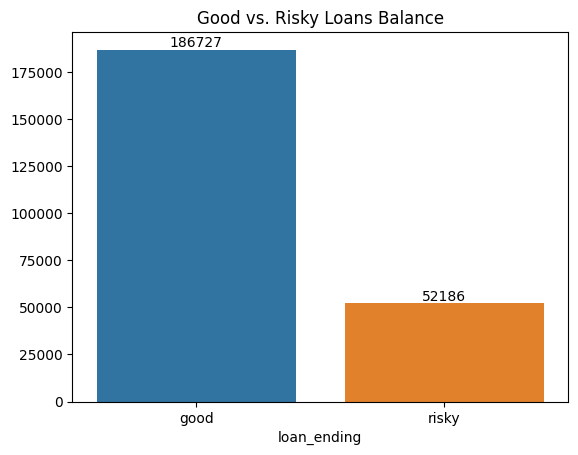

In [12]:
# Counting the value of Good and Risky Loans Balance with Barplot
plt.title('Good vs. Risky Loans Balance')
sns.barplot(x=df['loan_ending'].value_counts().index, y=df['loan_ending'].value_counts().values)

# Add value labels
for i, v in enumerate(df['loan_ending'].value_counts().values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

## Column understanding & data leakage

Based on the provided information, we can categorize the columns in the dataset into different groups based on their relevance and data leakage concerns:

* Columns related to the loan's basic characteristics:

'id'
'loan_amnt'
'funded_amnt'
'funded_amnt_inv'
'term'
'int_rate'
'installment'
'grade'
'sub_grade'
'application_type'

* Columns related to the borrower's basic identity:

'member_id'
'emp_title'
'emp_length'
'home_ownership'
'annual_inc'
'verification_status'
'zip_code'
'addr_state'
'dti'

* Columns related to the borrower's personal records:

'delinq_2yrs'
'earliest_cr_line'
'inq_last_6mths'
'mths_since_last_delinq'
'mths_since_last_record'
'open_acc'
'pub_rec'
'revol_bal'
'revol_util'
'total_acc'
'initial_list_status'
'mths_since_last_major_derog'
'acc_now_delinq'

* Columns related to the current status of the loan (after it is issued) - Data Leakage concerns:

'issue_d'
'loan_status'
'pymnt_plan'
'out_prncp'
'out_prncp_inv'
'total_pymnt'
'total_pymnt_inv'
'total_rec_prncp'
'total_rec_int'
'total_rec_late_fee'
'recoveries'
'collection_recovery_fee'
'last_pymnt_d'
'last_pymnt_amnt'
'next_pymnt_d'

As mentioned, the focus is on predicting loan risk before investing in the loan, so columns containing data leakage (related to the current status of the loan) should be dropped. These columns provide information that is only available after the loan is issued and do not contribute to predicting loan risk before investment.

By excluding the columns with data leakage, we ensure that the model is built using only the data that can be obtained before investing in the loan. This approach avoids data leakage issues and ensures the model's practicality and usefulness in production.

In [13]:
# Checking the remaining columns on the dataset
df.columns

Index(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url',
       'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'l

## Feature Selection
To ensure that our machine learning model is trained on relevant features, we need to drop certain columns from our dataset. These columns include:

**Future Data Columns:**

* 'total_pymnt': Represents the total payment made by the loaner.
* 'last_pymnt_d': Indicates the date of the last payment made.
* 'last_pymnt_amnt': Represents the amount of the last payment made.

Note: These columns provide information that is only available after the loan has been disbursed. Since our goal is to predict loan outcomes before granting the loans, we need to exclude these variables from our machine learning model.

**Features with a High Number of Unique Values:**

* 'id': A unique identifier for each loan.
* 'member_id': A unique identifier for each member.
* 'url': Represents the URL of the loan listing.

Note: These columns have a large number of unique values, which may not provide significant predictive power for our model. Hence, we can exclude them from our feature set.

**Features with a Single Value:**

* 'policy_code': Represents a policy code.
* 'application_type': Indicates the type of loan application.

Note: These columns have a single value across the entire dataset, which means they do not provide any useful information for predicting loan outcomes. Hence, we can safely exclude them from our feature set.

By dropping these columns, we ensure that our machine learning model focuses on relevant features that are available before the loan is granted. This helps us make accurate predictions and avoid data leakage.

In [14]:
# Drop the leakage columns
leakage_col = ['Unnamed: 0', 'issue_d', 'loan_status', 'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
                   'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 
                   'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'zip_code', 'title', 'emp_title']
dropped_data = df[leakage_col]

df.drop(columns=leakage_col, axis=1, inplace=True)

In [15]:
# Check for suspected duplicated columns based on common sense
duplicate_col = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'grade', 'sub_grade', 'desc', 'purpose']
df[duplicate_col]

,loan_amnt,funded_amnt,funded_amnt_inv,grade,sub_grade,desc,purpose
0,5000,5000,4975.0,B,B2,Borrower added on 12/22/11 > I need to upgra...,credit_card
1,2500,2500,2500.0,C,C4,Borrower added on 12/22/11 > I plan to use t...,car
2,2400,2400,2400.0,C,C5,NaN,small_business
3,10000,10000,10000.0,C,C1,Borrower added on 12/21/11 > to pay for prop...,other
5,5000,5000,5000.0,A,A4,NaN,wedding
...,...,...,...,...,...,...,...
466276,8525,8525,8525.0,D,D3,NaN,medical
466277,18000,18000,17975.0,A,A4,Borrower added on 12/09/13 > consolidate all...,debt_consolidation
466278,10000,10000,10000.0,D,D3,NaN,vacation
466281,22000,22000,22000.0,D,D5,NaN,debt_consolidation


In [16]:
resumetable(df) #print resume table of the dataset

Dataset Shape: (238913, 39)


,Name,dtypes,Missing,Uniques,Sample Value,Entropy
id,id,int64,0,238913,1077501,5.38
member_id,member_id,int64,0,238913,1296599,5.38
loan_amnt,loan_amnt,int64,0,1310,5000,2.15
funded_amnt,funded_amnt,int64,0,1313,5000,2.16
funded_amnt_inv,funded_amnt_inv,float64,0,9560,4975.0,2.48
term,term,object,0,2,36 months,0.23
int_rate,int_rate,float64,0,505,10.65,2.17
installment,installment,float64,0,43848,162.87,4.13
grade,grade,object,0,7,B,0.71
sub_grade,sub_grade,object,0,35,B2,1.41


In [17]:
# Print descriptive statistics of selected columns
print(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())

           loan_amnt    funded_amnt  funded_amnt_inv
count  238913.000000  238913.000000    238913.000000
mean    13486.214647   13440.797173     13312.662461
std      8066.725464    8042.190169      8080.099456
min       500.000000     500.000000         0.000000
25%      7200.000000    7200.000000      7125.000000
50%     12000.000000   12000.000000     11914.311470
75%     18000.000000   18000.000000     18000.000000
max     35000.000000   35000.000000     35000.000000


In [18]:
# Based on the output, the columns 'funded_amnt', 'funded_amnt_inv', and others mentioned above are very similar.
# Therefore, we can remove 'funded_amnt', 'funded_amnt_inv', 'id', 'member_id', 'url', and 'desc'.
drop_col = ['funded_amnt', 'funded_amnt_inv', 'id', 'member_id', 'url', 'desc']
dropped_data = pd.concat([dropped_data, df[drop_col]], axis=1)
df.drop(columns=drop_col, axis=1, inplace=True)

In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,238913.0,13486.214647,8066.725464,500.00,7200.00,12000.00,18000.00,35000.00
int_rate,238913.0,13.855453,4.380770,5.42,10.99,13.67,16.59,26.06
installment,238913.0,416.935049,243.750417,15.67,239.41,365.23,545.96,1408.13
annual_inc,238909.0,71928.661725,55104.204330,1896.00,45000.00,61450.00,86000.00,7141778.00
dti,238913.0,16.439675,7.698582,0.00,10.72,16.14,21.88,39.99
delinq_2yrs,238884.0,0.248300,0.735872,0.00,0.00,0.00,0.00,29.00
inq_last_6mths,238884.0,0.906859,1.173756,0.00,0.00,1.00,1.00,33.00
mths_since_last_delinq,105385.0,34.909408,21.839102,0.00,16.00,32.00,51.00,152.00
open_acc,238884.0,10.858325,4.827772,0.00,7.00,10.00,13.00,76.00
pub_rec,238884.0,0.134932,0.421437,0.00,0.00,0.00,0.00,11.00


In [20]:
# Check the values of 'acc_now_delinq' when 'mths_since_last_delinq' is NaN
df[df['mths_since_last_delinq'].isna()]['acc_now_delinq'].value_counts()

acc_now_delinq
0.0    133499
Name: count, dtype: int64

In [21]:
# Columns related to personal record
personal_record = ['mths_since_last_delinq', 'mths_since_last_major_derog']
df[personal_record]

,mths_since_last_delinq,mths_since_last_major_derog
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,35.0,NaN
5,NaN,NaN
...,...,...
466276,3.0,4.0
466277,14.0,14.0
466278,29.0,32.0
466281,NaN,NaN


In [22]:
# Create a new column 'major_derogatory' indicating whether a major derogatory event occurred
df['major_derogatory'] = np.where(df['mths_since_last_major_derog'].isna(), 0, 1)

# Drop columns related to personal record
drop_col = ['mths_since_last_delinq', 'mths_since_last_major_derog']
dropped_data = pd.concat([dropped_data, df[drop_col]], axis=1)
df.drop(columns=drop_col, axis=1, inplace=True)

In [23]:
# Columns for pivot table analysis
cols = ['tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

# Pivot table aggregated by mean
print(pd.pivot_table(df, index='loan_ending', values=cols))

# Pivot table aggregated by max value
print(pd.pivot_table(df, index='loan_ending', values=cols, aggfunc=np.max))

             tot_coll_amt    tot_cur_bal  total_rev_hi_lim
loan_ending                                               
good           219.721618  143006.253262      29996.098672
risky          141.355723  116108.175291      26256.733754
             tot_coll_amt  tot_cur_bal  total_rev_hi_lim
loan_ending                                             
good            9152545.0    8000078.0         2013133.0
risky             95806.0    3437283.0         1998700.0


In [24]:
# Based on the pivot table, 'tot_coll_amt' appears suspicious. Further investigation:
df[cols].describe()

,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,1.722900e+05,1.722900e+05,1.722900e+05
mean,2.009637e+02,1.365678e+05,2.910103e+04
std,2.211009e+04,1.501802e+05,2.854495e+04
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.795400e+04,1.320000e+04
50%,0.000000e+00,7.923900e+04,2.200000e+04
75%,0.000000e+00,2.064025e+05,3.620000e+04
max,9.152545e+06,8.000078e+06,2.013133e+06


In [25]:
# Drop suspicious columns
drop_col = ['tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']
dropped_data = pd.concat([dropped_data, df[drop_col]], axis=1)
df.drop(columns=drop_col, inplace=True)

In [26]:
# Filtering columns with less than 10 unique values
df.nunique()[df.nunique() < 10].sort_values().index

Index(['policy_code', 'application_type', 'term', 'initial_list_status',
       'loan_ending', 'major_derogatory', 'verification_status',
       'home_ownership', 'acc_now_delinq', 'grade',
       'collections_12_mths_ex_med'],
      dtype='object')

In [27]:
# Dropping columns 'policy_code' and 'application_type'
df.drop(['policy_code', 'application_type'], inplace=True, axis=1)

In [28]:
# Separate numerical and categorical columns
num_data = df.select_dtypes(exclude= 'object')
num_data.columns
cat_data = df.select_dtypes(include= 'object')
cat_data.columns

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'purpose', 'addr_state', 'earliest_cr_line',
       'initial_list_status', 'last_credit_pull_d', 'loan_ending'],
      dtype='object')

In [29]:
# Columns for categorical data analysis
cols = ['emp_length', 'earliest_cr_line', 'last_credit_pull_d']
cat_data[cols].head()

,emp_length,earliest_cr_line,last_credit_pull_d
0,10+ years,Jan-85,Jan-16
1,< 1 year,Apr-99,Sep-13
2,10+ years,Nov-01,Jan-16
3,10+ years,Feb-96,Jan-15
5,3 years,Nov-04,Sep-15


In [30]:
df['emp_length'].unique() #see unique value from the column

array(['10+ years', '< 1 year', '3 years', '9 years', '4 years',
       '5 years', '1 year', '6 years', '2 years', '7 years', '8 years',
       nan], dtype=object)

In [31]:
# Map 'emp_length' values to numeric format
emp_map = {
    '< 1 year': '0',
    '1 year': '1',
    '2 years': '2',
    '3 years': '3',
    '4 years': '4',
    '5 years': '5',
    '6 years': '6',
    '7 years': '7',
    '8 years': '8',
    '9 years': '9',
    '10+ years': '10'
}

df['emp_length'] = df['emp_length'].map(emp_map).fillna('0').astype(int)
df['emp_length'].unique()

array([10,  0,  3,  9,  4,  5,  1,  6,  2,  7,  8])

In [32]:
# Extract year from 'earliest_cr_line' and calculate years since last inquiry
df['earliest_cr_yr'] = pd.to_datetime(df['earliest_cr_line'], format="%b-%y").dt.year
df['yr_since_last_inq'] = 2016 - pd.to_datetime(df['last_credit_pull_d'], format="%b-%y").dt.year

# Summary statistics for selected columns
df[['emp_length', 'earliest_cr_yr', 'yr_since_last_inq']].describe()

,emp_length,earliest_cr_yr,yr_since_last_inq
count,238913.000000,238884.000000,238890.000000
mean,5.566637,1997.710554,0.959149
std,3.716528,7.486129,1.162644
min,0.000000,1969.000000,0.000000
25%,2.000000,1994.000000,0.000000
50%,5.000000,1999.000000,1.000000
75%,10.000000,2002.000000,1.000000
max,10.000000,2068.000000,9.000000


In [33]:
# Filter out rows where 'earliest_cr_yr' is greater than or equal to 2016
df = df[df['earliest_cr_yr'] < 2016]

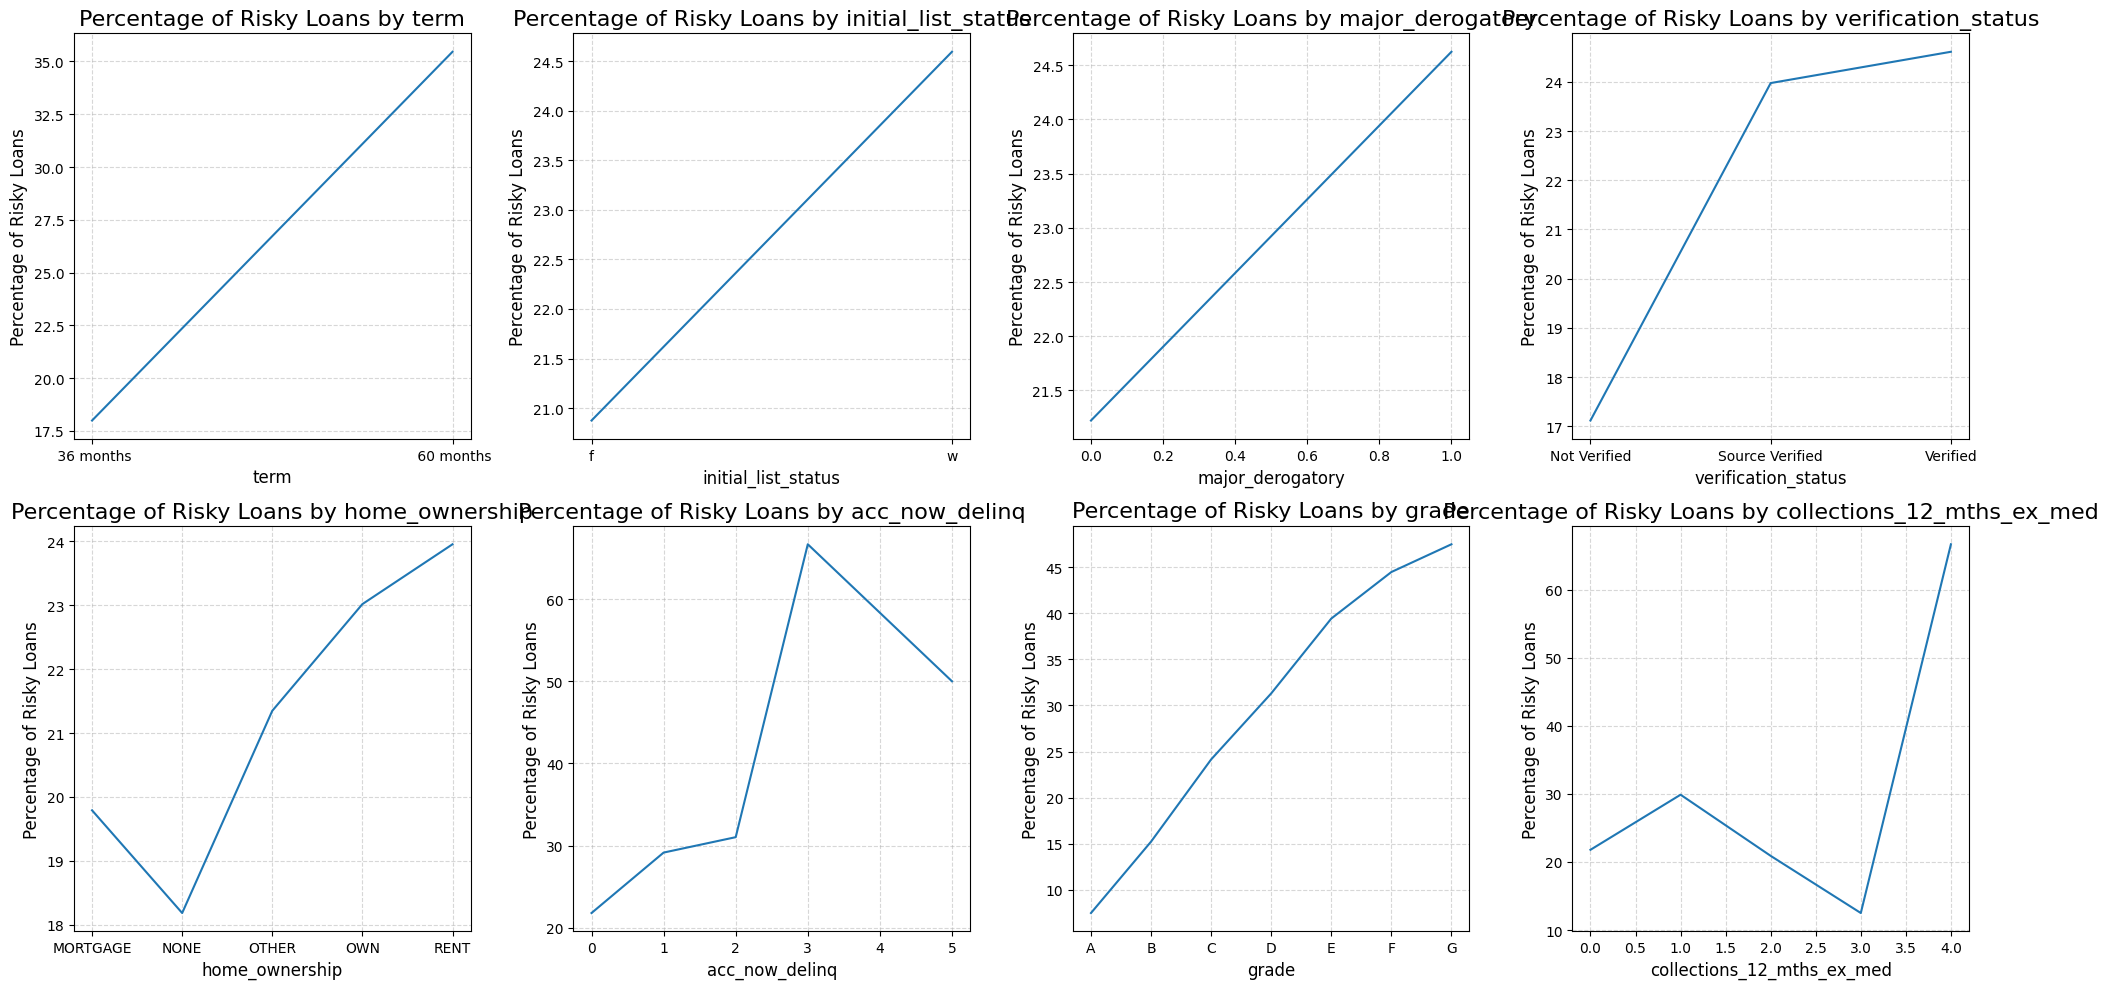

In [34]:
# Create subplots for risk percentage charts
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# List of columns for risk percentage chart
small_unique = ['term', 'initial_list_status', 'major_derogatory', 'verification_status',
                'home_ownership', 'acc_now_delinq', 'grade', 'collections_12_mths_ex_med']

# Generate risk percentage charts for each column in 'small_unique'
for i, col in enumerate(small_unique):
    plot_risk_percentage(col, df, ax=axes[i // 4, i % 4])

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [35]:
# Columns to drop after visualization
to_drop = ['earliest_cr_line', 'last_credit_pull_d']
dropped_data = pd.concat([dropped_data, df[to_drop]], axis=1)

# Separate numerical and categorical data after dropping columns
num_data = df.drop(to_drop, axis=1).select_dtypes(exclude='object')
cat_data = df.drop(to_drop, axis=1).select_dtypes(include='object')

# Print numerical and categorical column names
print('Numerical columns:', num_data.columns)
print('Categorical columns:', cat_data.columns)

Numerical columns: Index(['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'major_derogatory', 'earliest_cr_yr',
       'yr_since_last_inq'],
      dtype='object')
Categorical columns: Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'purpose', 'addr_state', 'initial_list_status', 'loan_ending'],
      dtype='object')


In [36]:
cat_data.head()

,term,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,initial_list_status,loan_ending
0,36 months,B,B2,RENT,Verified,credit_card,AZ,f,good
1,60 months,C,C4,RENT,Source Verified,car,GA,f,risky
2,36 months,C,C5,RENT,Not Verified,small_business,IL,f,good
3,36 months,C,C1,RENT,Source Verified,other,CA,f,good
5,36 months,A,A4,RENT,Source Verified,wedding,AZ,f,good


### Numerical Data Discovery

In this Numerical Data Discovery section, we perform various analyses on the numerical columns. We start by plotting distribution histograms to visualize the distribution of each numerical column. Then, we generate a correlation heatmap to examine the relationships between numerical columns. Based on the heatmap, we identify highly correlated columns and drop them to reduce multicollinearity. Finally, we display an updated correlation heatmap after dropping the highly correlated columns. These steps help us understand the numerical data and make informed decisions about feature selection.

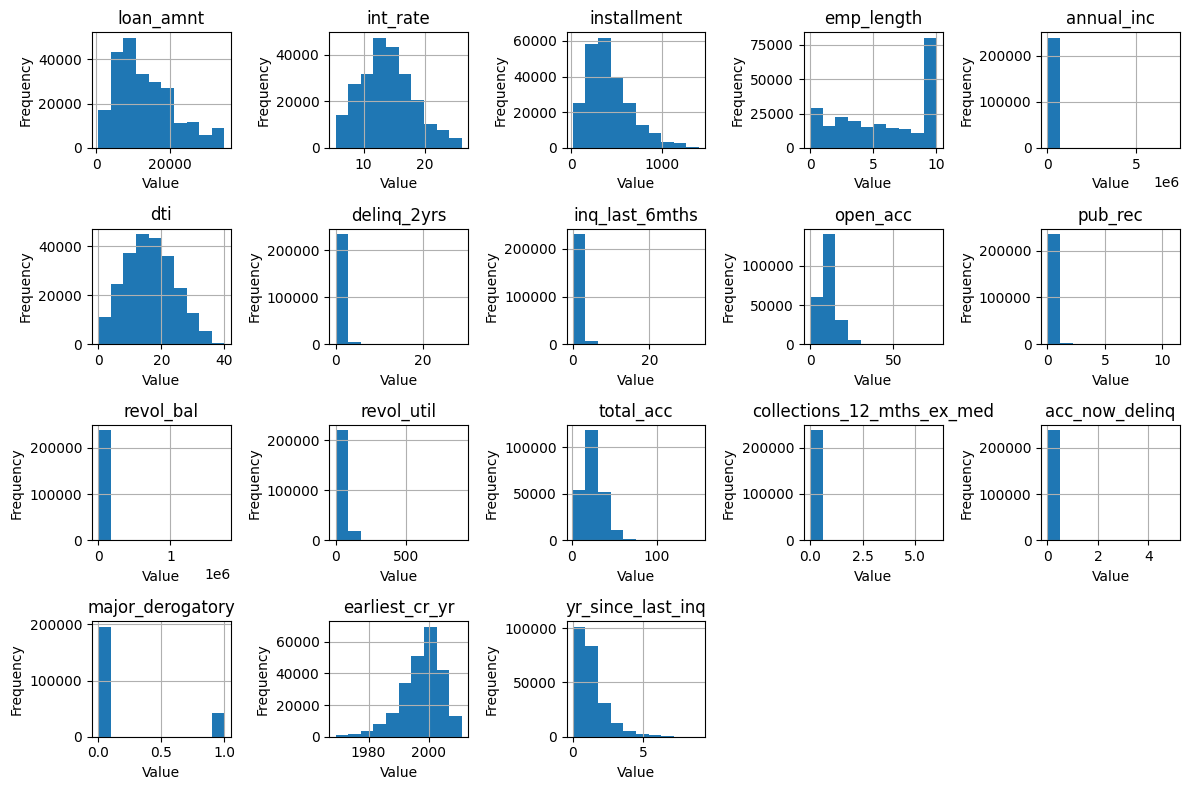

In [37]:
# 1. Distribution Plots
# Determine the number of subplots required
num_cols = len(num_data.columns)
num_rows = math.ceil(num_cols / 5)

# Create the subplots
plt.figure(figsize=(12, 8))
colors = ['#1f77b4'] * num_cols  # Set a consistent color palette

for i, col in enumerate(num_data.columns):
    plt.subplot(num_rows, 5, i+1)
    plt.hist(num_data[col], color=colors[i])
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

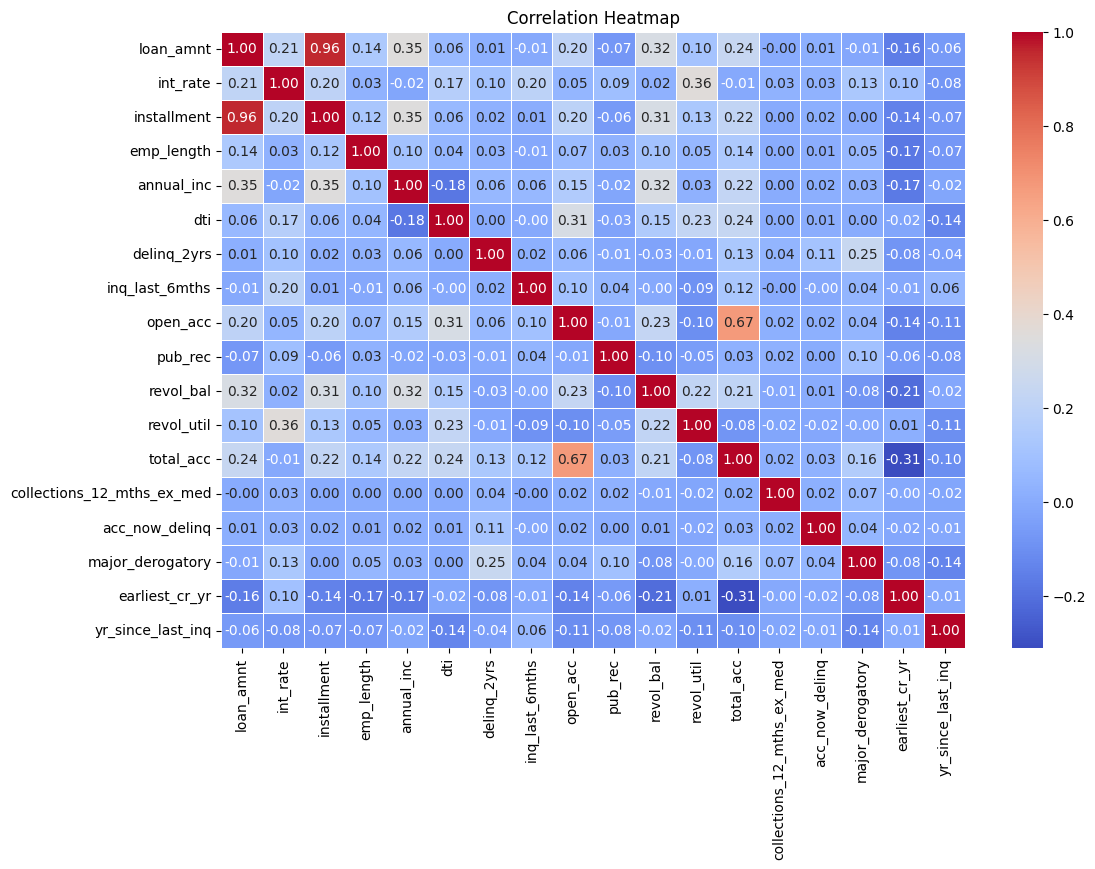

In [38]:
# 2. Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data=num_data.corr(), annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Heatmap')
plt.xticks(fontsize=10)  # Increase font size for x-axis labels
plt.yticks(fontsize=10)  # Increase font size for y-axis labels
plt.show()

# The distribution plots provide visualizations of the distribution of each numerical column in the dataset.
# The correlation heatmap shows the correlation coefficients between pairs of numerical columns.
# Based on the heatmap, we can identify highly correlated columns.

From the heatmap I can see that, some of my columns has high correlation.

It's more good that we just drop the columns

In [39]:
# 3. pivot table
pd.pivot_table(df, index = 'loan_ending', values = num_data.columns)

# The pivot table provides an aggregated view of numerical columns based on the 'loan_ending' index.
# It can help identify patterns or trends in the data based on the 'loan_ending' period.

,acc_now_delinq,annual_inc,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_yr,emp_length,inq_last_6mths,installment,int_rate,loan_amnt,major_derogatory,open_acc,pub_rec,revol_bal,revol_util,total_acc,yr_since_last_inq
loan_ending,,,,,,,,,,,,,,,,,,
good,0.002587,73686.164671,0.005412,0.236165,15.920096,1997.434908,5.587686,0.872580,409.768577,13.265707,13167.634542,0.171615,10.786252,0.130941,15235.640579,53.724019,24.938820,0.981661
risky,0.003959,65627.606648,0.007845,0.290986,18.304076,1998.026562,5.509495,1.029425,442.595120,15.976388,14624.669902,0.200788,11.113569,0.148318,15126.616048,59.599248,24.328407,0.874962


In [40]:
# Dropping Highly Correlated Columns
correlation_threshold = 0.65  # Define correlation threshold

# Find column names with correlation value more than the threshold
highly_correlated_cols = correlation(num_data, correlation_threshold)

# Drop the highly correlated columns from the numerical data
num_data.drop(highly_correlated_cols, axis=1, inplace=True)

C:\Users\basha\AppData\Local\Temp\ipykernel_3924\3002439837.py:85: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


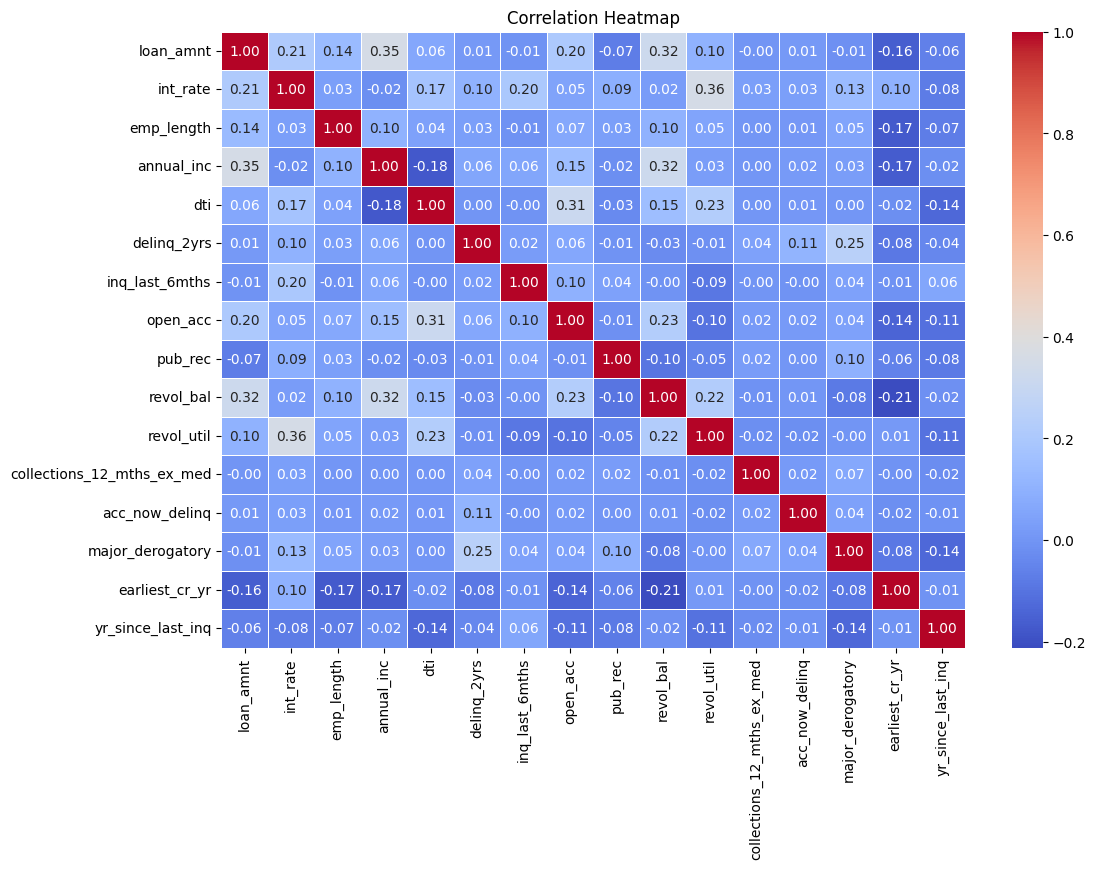

In [41]:
# Review the heatmap after dropping data
plt.figure(figsize=(12, 8))
sns.heatmap(data=num_data.corr(), annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Heatmap')
plt.xticks(fontsize=10)  # Increase font size for x-axis labels
plt.yticks(fontsize=10)  # Increase font size for y-axis labels
plt.show()

# The highly correlated columns are dropped from the numerical data.
# The updated correlation heatmap shows the remaining correlations between columns.
# This helps to reduce multicollinearity and improves the interpretability of the data.

### Categorical Data Discovery

In the Categorical Data Discovery section, we perform various operations on the categorical columns. We generate risk percentage charts to visualize the distribution of risk across different categorical columns. We transform and encode specific categorical columns such as 'term' and 'grade' to ensure they are in the appropriate format for analysis. We then perform one-hot encoding on selected categorical columns using pandas get_dummies function. The resulting one-hot encoded columns are concatenated with the remaining categorical columns. Finally, we combine the numerical and categorical data to create the final dataset for further analysis or modeling.

In [42]:
# List of categorical columns
categorical_cols = cat_data.columns
categorical_cols

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'purpose', 'addr_state', 'initial_list_status', 'loan_ending'],
      dtype='object')

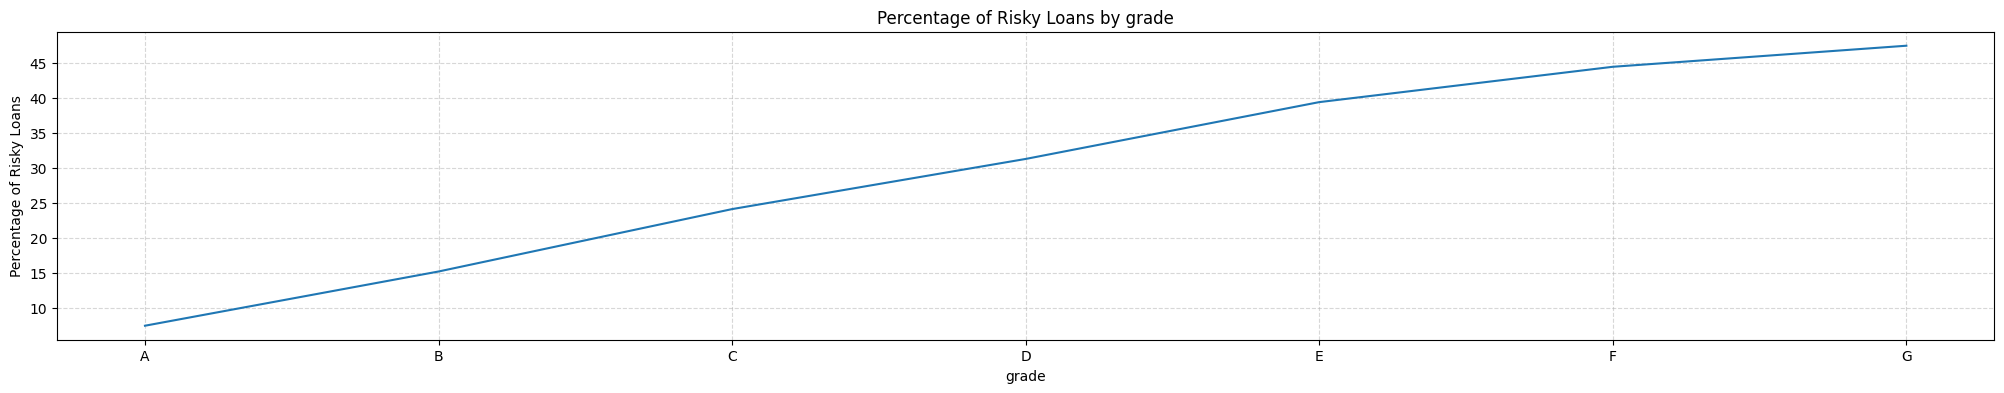

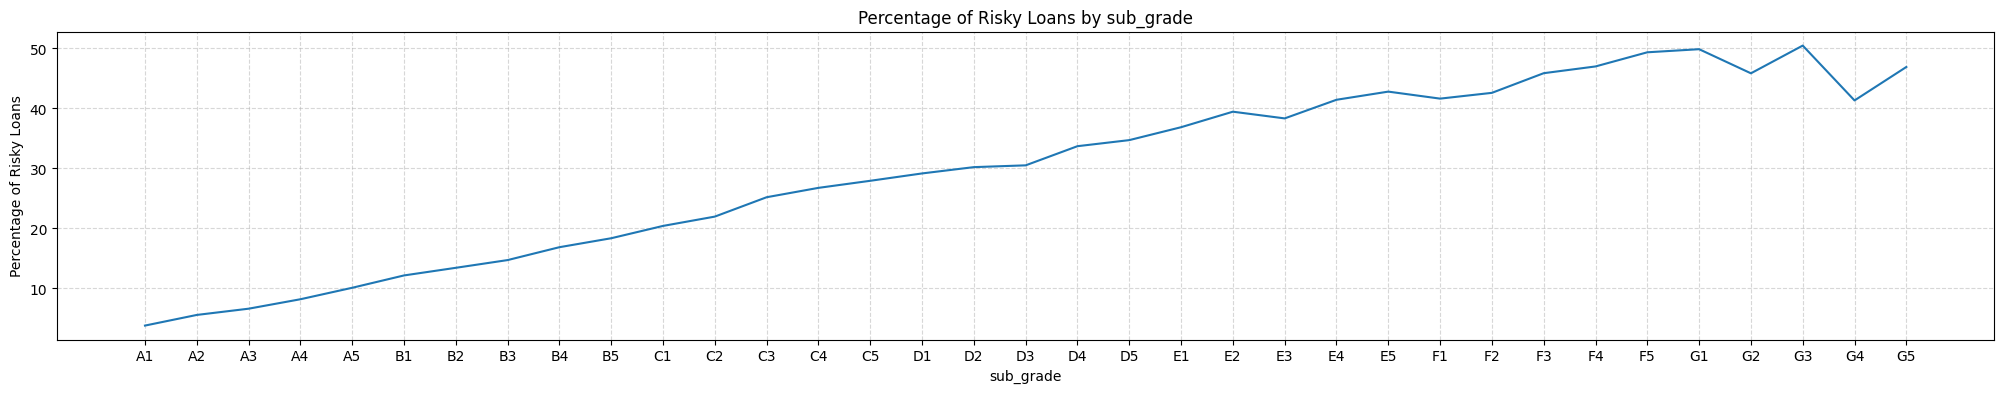

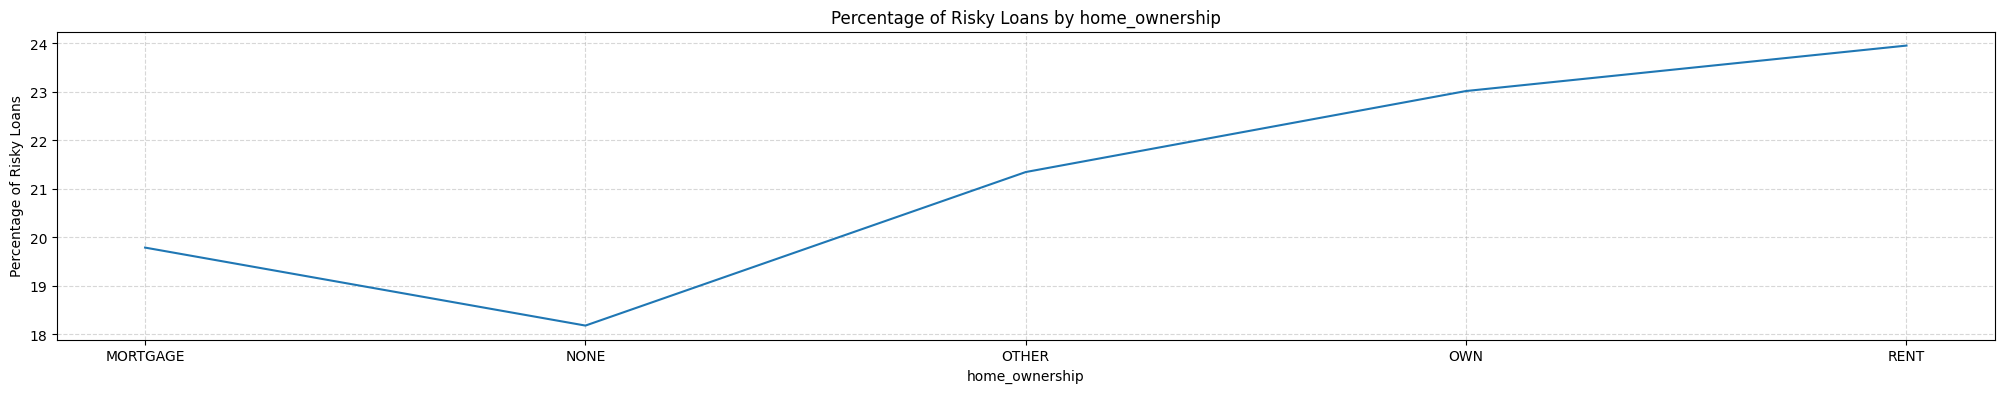

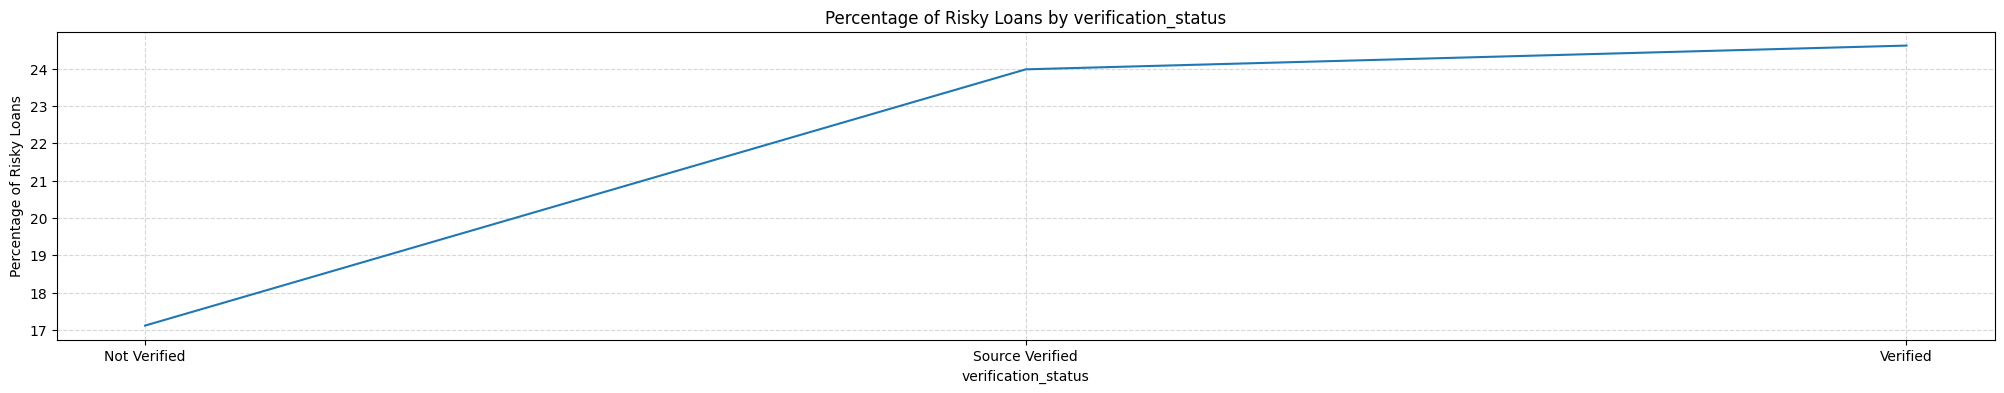

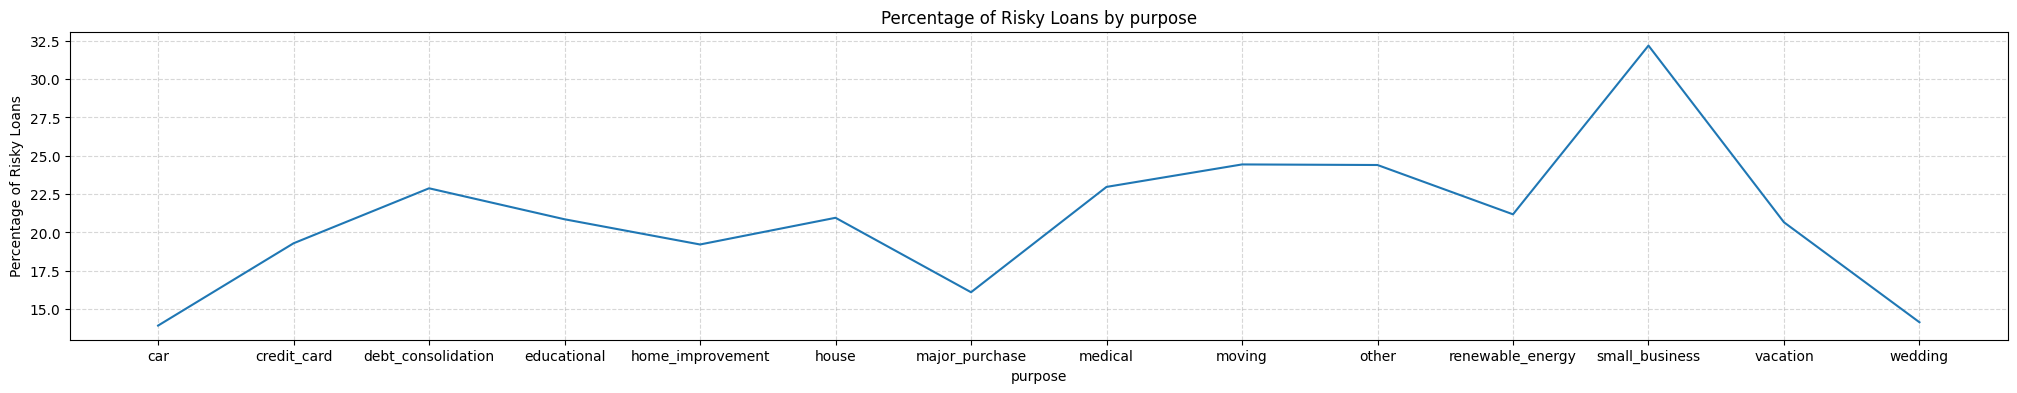

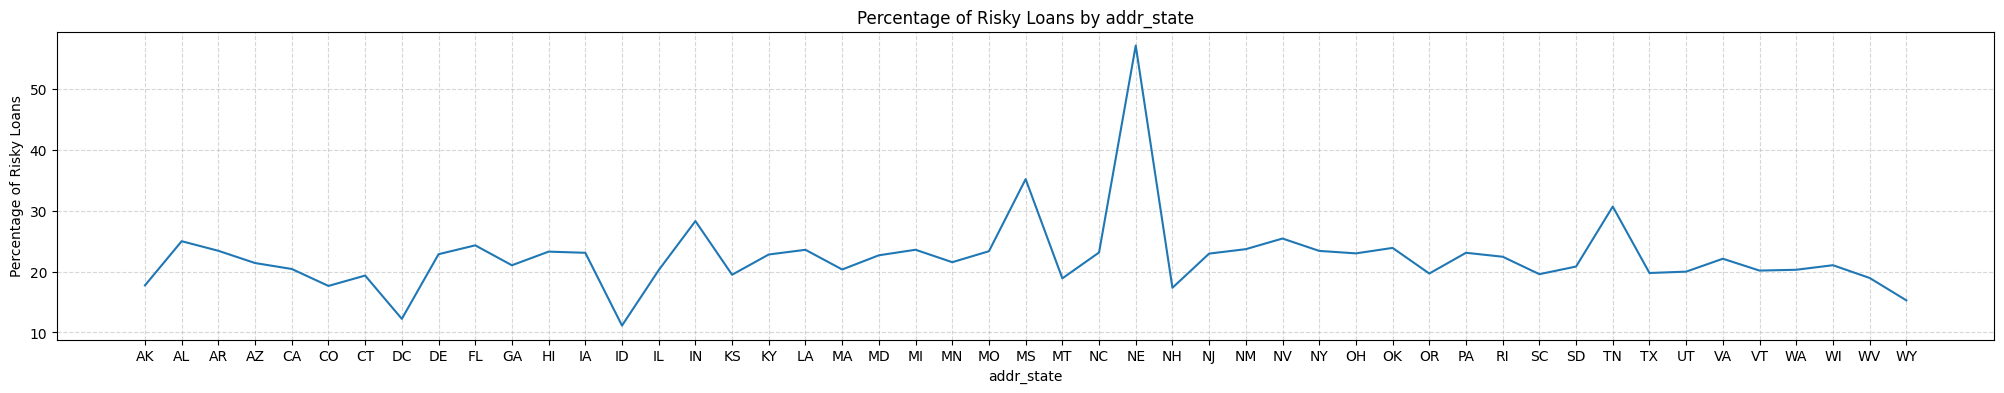

In [43]:
# Columns to generate risk percentage charts
to_chart = ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state']

# Generate risk percentage charts for each column in to_chart
for col in to_chart:
    plt.figure(figsize=(25, 4))
    risk_pct_chart(col)

# The risk percentage charts provide insights into the distribution of risk across different categorical columns.
# Each chart visualizes the percentage of bad loans (defaulted or charged off) for each category within the column.

In [44]:
dropped_data = pd.concat([dropped_data, df['sub_grade']], axis=1)
cat_data.drop('sub_grade', axis=1, inplace=True)

# Number of unique values in each categorical column
cat_data.nunique()

# The number of unique values in each categorical column helps assess the cardinality of the categorical data.

term                    2
grade                   7
home_ownership          6
verification_status     3
purpose                14
addr_state             50
initial_list_status     2
loan_ending             2
dtype: int64

In [45]:
# 1. Transforming 'term' column
cat_data['term'] = cat_data['term'].str.replace(' months', '').astype(int)

In [46]:
cat_data['grade'].unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [47]:
# 2. Transforming 'grade' column
grade_map = {
    'A' : 1,
    'B' : 2,
    'C' : 3,
    'D' : 4,
    'E' : 5,
    'F' : 6,
    'G' : 7,
}

cat_data['grade'] = cat_data['grade'].map(grade_map)

In [48]:
# 3. One-hot encoding categorical columns
to_dummies = ['home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status']

dummies = pd.get_dummies(cat_data[to_dummies])
dummies.drop('initial_list_status_w', axis=1, inplace=True)

In [49]:
# Dropping columns that have already been one-hot encoded
dropped_data = pd.concat([dropped_data, cat_data[to_dummies]], axis = 1)
cat_data.drop(to_dummies, axis=1, inplace=True)

In [50]:
# Combining categorical data with one-hot encoded data
cat_data_f = pd.concat([cat_data, dummies], axis = 1)

In [51]:
# Combining numerical and categorical data
final_data = pd.concat([num_data, cat_data_f], axis = 1).dropna().reset_index().drop('index', axis = 1)
final_data.head()

# The categorical columns are transformed and one-hot encoded, and then combined with the numerical data to create the final dataset.
# The resulting dataset contains both numerical and categorical features, ready for further analysis or modeling.

,loan_amnt,int_rate,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f
0,5000,10.65,10,24000.0,27.65,0.0,1.0,3.0,0.0,13648,...,False,False,False,False,False,False,False,False,False,True
1,2500,15.27,0,30000.0,1.00,0.0,5.0,3.0,0.0,1687,...,False,False,False,False,False,False,False,False,False,True
2,2400,15.96,10,12252.0,8.72,0.0,2.0,2.0,0.0,2956,...,False,False,False,False,False,False,False,False,False,True
3,10000,13.49,10,49200.0,20.00,0.0,1.0,10.0,0.0,5598,...,False,False,False,False,False,False,False,False,False,True
4,5000,7.90,3,36000.0,11.20,0.0,3.0,9.0,0.0,7963,...,False,False,False,False,False,False,False,False,False,True


In [52]:
# separate dependant (y) and independant (X) variable
X = final_data.drop('loan_ending', axis = 1)
y = final_data['loan_ending']

In [53]:
# Perform undersampling using RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [54]:
# Print class distribution after resampling
class_counts = y_resampled.value_counts()
print(class_counts)

loan_ending
good     51945
risky    51945
Name: count, dtype: int64


In [55]:
# Split the resampled data into training and testing sets
train_X, val_X, train_y, val_y = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=400)

print('Number of rows in training set:', len(train_X))
print('Number of rows in testing set:', len(val_X))

Number of rows in training set: 83112
Number of rows in testing set: 20778


In [56]:
# splitting for training and model validation, it's important to avoid overfitting
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

In [57]:
# Splitting the data for train and validation
data_train_y = np.where(train_y == 'good', 1, 0)
data_val_y = np.where(val_y == 'good', 1, 0)

## Modelling

In the Modelling section, we evaluate several machine learning models for loan classification. We start with a baseline approach that accepts all loans without using any machine learning techniques. Then, we train and evaluate the performance of the following classifiers: Decision Tree, K-Nearest Neighbors (KNN), Random Forest, XGBoost, and an ensemble Soft Voting Classifier.

For each model, we print the classification report, which includes precision, recall, f1-score, and accuracy metrics. We also store these metrics in dictionaries for each model. Finally, we create a heatmap using the stored metrics and visualize the model performance. The heatmap provides a comparison of the models based on precision, recall, f1-score, and accuracy, with brighter colors indicating better performance.

This analysis helps in assessing the effectiveness of different models in predicting loan default or charge-off, allowing for the selection of the most suitable model for the task at hand.

Baseline Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00     12822
           1       0.78      1.00      0.88     46686

    accuracy                           0.78     59508
   macro avg       0.89      0.50      0.44     59508
weighted avg       0.83      0.78      0.69     59508

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.34      0.33     12822
           1       0.82      0.81      0.81     46686

    accuracy                           0.70     59508
   macro avg       0.57      0.57      0.57     59508
weighted avg       0.71      0.70      0.71     59508

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.11      0.16     12822
           1       0.79      0.92      0.85     46686

    accuracy                           0.74     59508
   macro avg       0.53      

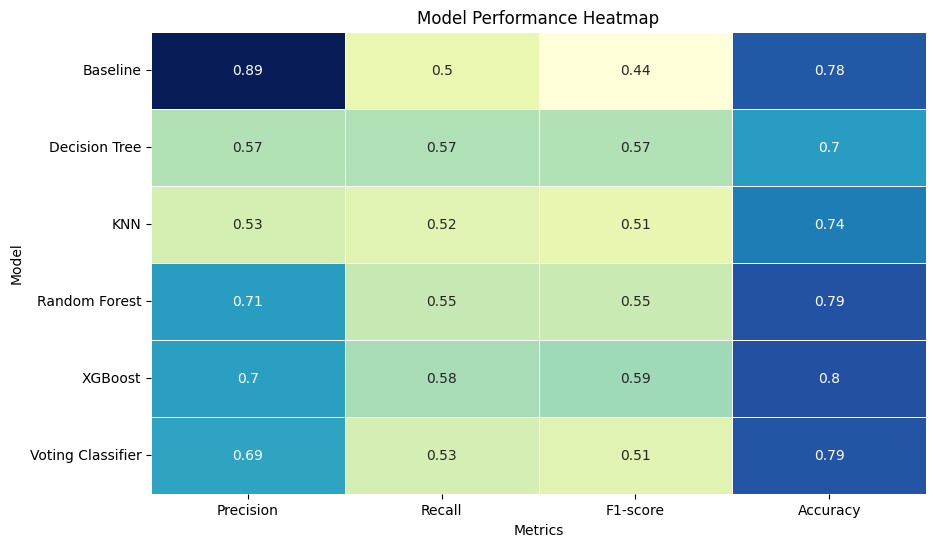

In [58]:
# Baseline approach: Accept all loans without using ML
pred_y_baseline = np.ones_like(data_val_y)
print("Baseline Classification Report:\n", classification_report(data_val_y, pred_y_baseline, zero_division=1))

# Decision Tree Classifier
dt = tree.DecisionTreeClassifier(random_state=14)
dt.fit(train_X, data_train_y)
pred_y_dt = dt.predict(val_X)
print("Decision Tree Classification Report:\n", classification_report(data_val_y, pred_y_dt, zero_division=1))

# K-Nearest Neighbors (KNN) Classifier
knn = KNeighborsClassifier()
knn.fit(train_X, data_train_y)
pred_y_knn = knn.predict(val_X)
print("KNN Classification Report:\n", classification_report(data_val_y, pred_y_knn, zero_division=1))

# Random Forest Classifier
rf = RandomForestClassifier(random_state=14)
rf.fit(train_X, data_train_y)
pred_y_rf = rf.predict(val_X)
print("Random Forest Classification Report:\n", classification_report(data_val_y, pred_y_rf, zero_division=1))

# XGBoost Classifier
xgb = XGBClassifier(random_state=14)
xgb.fit(train_X, data_train_y)
pred_y_xgb = xgb.predict(val_X)
print("XGBoost Classification Report:\n", classification_report(data_val_y, pred_y_xgb, zero_division=1))

# Ensemble Soft Voting Classifier
voting_clf = VotingClassifier(estimators=[('knn', knn), ('rf', rf), ('xgb', xgb)], voting='soft')
voting_clf.fit(train_X, data_train_y)
pred_y_voting = voting_clf.predict(val_X)
print("Voting Classifier Classification Report:\n", classification_report(data_val_y, pred_y_voting, zero_division=1))

# Create dictionaries to store the performance metrics
precision_dict = {}
recall_dict = {}
f1_dict = {}
accuracy_dict = {}

# Store precision, recall, f1-score, and accuracy in each model's dictionary
models = ['Baseline', 'Decision Tree', 'KNN', 'Random Forest', 'XGBoost', 'Voting Classifier']
predictions = [pred_y_baseline, pred_y_dt, pred_y_knn, pred_y_rf, pred_y_xgb, pred_y_voting]

for model, pred_y in zip(models, predictions):
    report = classification_report(data_val_y, pred_y, output_dict=True, zero_division=1)
    precision_dict[model] = report['macro avg']['precision']
    recall_dict[model] = report['macro avg']['recall']
    f1_dict[model] = report['macro avg']['f1-score']
    accuracy_dict[model] = report['accuracy']

# Create a DataFrame from the performance dictionaries
heatmap_data = pd.DataFrame({'Precision': precision_dict, 'Recall': recall_dict, 'F1-score': f1_dict, 'Accuracy': accuracy_dict})

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar=False, linewidths=0.5)
plt.title('Model Performance Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Model')
plt.show()


## Catboost

In the CatBoost section, we utilize the CatBoostClassifier algorithm to build a loan classification model. We begin by identifying categorical columns using the get_cat_cols function. Then, we split the data into training and validation sets and handle class imbalance by using the RandomUnderSampler to resample the data.

Next, we create CatBoost "Pools" for both the training and validation data, specifying the categorical features. We define the CatBoostClassifier model with desired hyperparameters and fit it to the training data, evaluating its performance on the validation data.

We encode the labels using LabelEncoder for evaluation metrics and generate classification reports, including precision, recall, f1-score, and roc_auc_score. We also plot a bar chart to display the top 10 feature importances.

Finally, we obtain predicted probabilities, which are stored in pred_proba, and plot a confusion matrix to visualize the performance of the CatBoost model.

In [59]:
cat = get_cat_cols(df)

# Separate dependent (y) and independent (X) variables
X = final_data.drop('loan_ending', axis=1)
y = final_data['loan_ending']

X_train, y_train = RandomUnderSampler(random_state=42).fit_resample(X, y)  # Randomly sample X, Y for balancing the data

train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)  # Split the data into train and test sets

catboost_cat_vars = [i for i, v in enumerate(X_train.columns) if v in cat]  # Get the number of categorical columns

print('catboost_cat_vars:', catboost_cat_vars)
print(y_train.value_counts())

catboost_cat_vars: [16, 17]
loan_ending
good     51945
risky    51945
Name: count, dtype: int64


In [60]:
# Insert the train data
train_pool = Pool(
    data=train_X,
    label=train_y,
    cat_features=catboost_cat_vars
)

# Insert the test data
test_pool = Pool(
    data=val_X,
    label=val_y,
    cat_features=catboost_cat_vars
)

In [61]:
model = CatBoostClassifier(random_seed=42,
                           learning_rate=0.1,
                           iterations=500,
                           depth=4,
                           custom_loss=['AUC', 'Accuracy'],
                           eval_metric='AUC')

model.fit(train_pool, eval_set=test_pool, verbose=100)

0:	test: 0.6835910	best: 0.6835910 (0)	total: 226ms	remaining: 1m 52s
100:	test: 0.7341564	best: 0.7341564 (100)	total: 6.55s	remaining: 25.9s
200:	test: 0.7404259	best: 0.7404259 (200)	total: 13.3s	remaining: 19.8s
300:	test: 0.7439335	best: 0.7439335 (300)	total: 19.6s	remaining: 13s
400:	test: 0.7453966	best: 0.7453966 (400)	total: 26.4s	remaining: 6.52s
499:	test: 0.7467568	best: 0.7467781 (497)	total: 32.6s	remaining: 0us

bestTest = 0.7467781201
bestIteration = 497

Shrink model to first 498 iterations.


In [62]:
print('Tree count:', model.tree_count_)  # Check the number of trees used in the model

Tree count: 498


In [63]:
label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)
val_y_encoded = label_encoder.transform(val_y)

# Encode predicted labels
train_x_pred_encoded = label_encoder.transform(model.predict(train_X))
val_x_pred_encoded = label_encoder.transform(model.predict(val_X))

print('Training -----')
print(classification_report(train_y_encoded, train_x_pred_encoded))
print('Testing -----')
print(classification_report(val_y_encoded, val_x_pred_encoded))

print('roc_auc_score')
print('Training:', roc_auc_score(train_y_encoded, model.predict_proba(train_X)[:, 1]))
print('Testing:', roc_auc_score(val_y_encoded, model.predict_proba(val_X)[:, 1]))

Training -----
              precision    recall  f1-score   support

           0       0.70      0.69      0.69     41556
           1       0.69      0.70      0.70     41556

    accuracy                           0.70     83112
   macro avg       0.70      0.70      0.70     83112
weighted avg       0.70      0.70      0.70     83112

Testing -----
              precision    recall  f1-score   support

           0       0.69      0.68      0.68     10389
           1       0.68      0.69      0.69     10389

    accuracy                           0.68     20778
   macro avg       0.68      0.68      0.68     20778
weighted avg       0.68      0.68      0.68     20778

roc_auc_score
Training: 0.7660123816144158
Testing: 0.7467781201343769


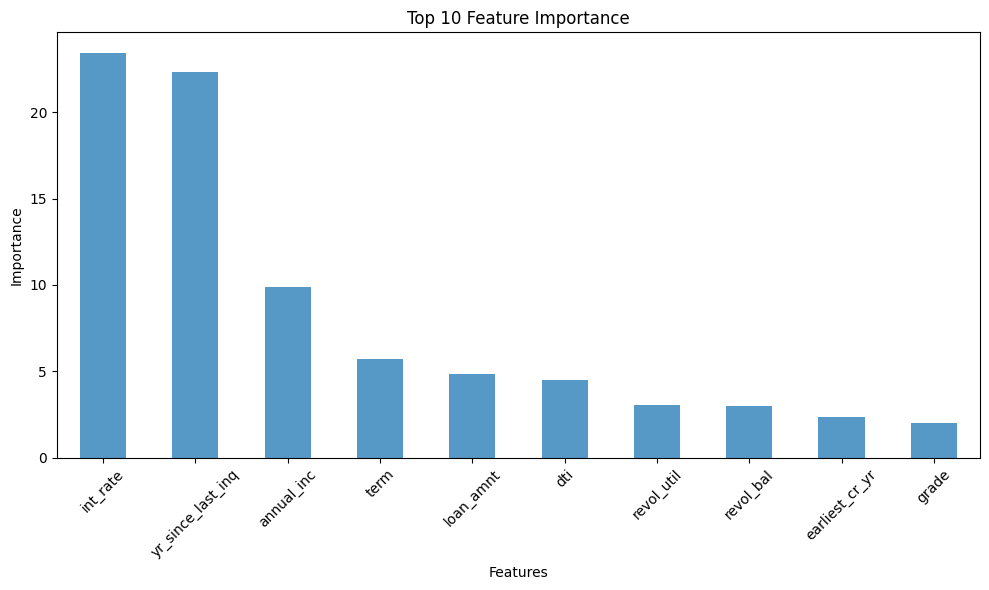

In [64]:
# Create a pandas Series to hold the feature importances
feature_importances = pd.Series(model.feature_importances_, index=model.feature_names_)

# Sort the feature importances in descending order
sorted_feature_importances = feature_importances.sort_values(ascending=False)

# Select only the first ten feature importances
top_feature_importances = sorted_feature_importances[:10]

# Plot the top ten feature importances as a bar chart
plt.figure(figsize=(10, 6))  # Set the figure size
top_feature_importances.plot(kind='bar', alpha=0.75)  # Plot the bar chart
plt.xlabel('Features')  # Set the x-axis label
plt.ylabel('Importance')  # Set the y-axis label
plt.title('Top 10 Feature Importance')  # Set the title
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust the spacing
plt.show()  # Display the plot

In [65]:
# Get predicted probabilities
model.predict_proba(val_X)[:,1]

array([0.32638881, 0.79506121, 0.35676505, ..., 0.59542724, 0.16670136,
       0.879601  ])

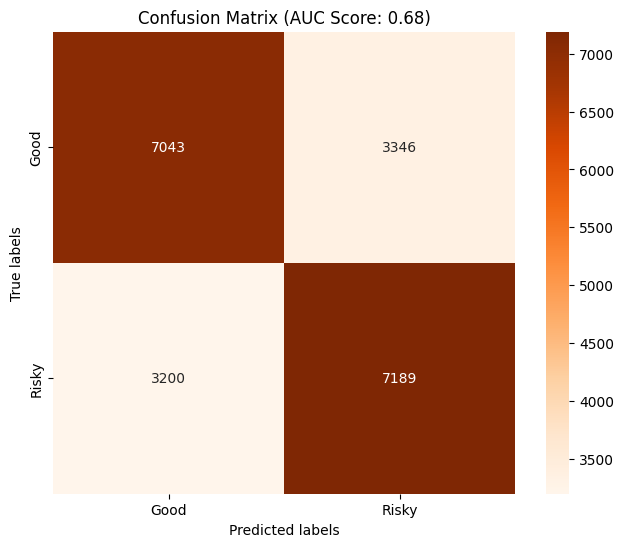

In [66]:
# Call the function to plot the confusion matrix
plot_confusion_matrix(model, val_x_pred_encoded, val_y_encoded)

## Conclusion